In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Input
from scikeras.wrappers import KerasRegressor
from sklearn.inspection import permutation_importance
from keras.optimizers import Adam, RMSprop

In [2]:
## Load Data

df_2019 = pd.read_csv('data/fantasy_data_2019.csv')
df_2020 = pd.read_csv('data/fantasy_data_2020.csv')
df_2021 = pd.read_csv('data/fantasy_data_2021.csv')
df_2022 = pd.read_csv('data/fantasy_data_2022.csv')
df_2023 = pd.read_csv('data/fantasy_data_2023.csv')

In [3]:
## Define and assign Fantasy points

## Calculates Fantasy points for each player in a dataframe
def fantasy_points(df):
  all_points = []
  for i,row in df.iterrows():
    player_points = 0
    player_points += 0.1 * (row['rush_yds'] + row['rec_yds'])
    player_points += 6 * (row['rush_td'] + row['rec_td'])
    player_points += (1/25) * row['pass_yds']
    player_points += (4) * row['pass_td']
    player_points += (-2) * row['int']
    player_points += (-2) * row['fumbles']
    all_points.append(player_points)
  return all_points

df_list = [df_2019, df_2020, df_2021, df_2022, df_2023]
for df in df_list:
  df['fantasy_pts'] = fantasy_points(df)


for i,df in enumerate(df_list):
  if i == 4:
    break
  temp = df_list[i+1].rename(columns = {'fantasy_pts': 'next_yr_pts'})
  df_list[i] = pd.merge(df, temp[['name', 'position', 'next_yr_pts']], on=['name', 'position'], how='inner')

df_2019 = df_list[0]
print(df_2019.columns)
df_2020 = df_list[1]
df_2021 = df_list[2]
df_2022 = df_list[3]

Index(['name', 'position', 'team_pts', 'opp_pts', 'cmp', 'att', 'pass_yds',
       'pass_td', 'int', 'rating', 'sacked', 'rush_att', 'rush_yds', 'rush_td',
       'tgt', 'rec_yds', 'rec_td', 'snap_pct', 'rec', 'age', 'fumbles',
       'games_played', 'yards_per_attempt_qb', 'yards_per_attempt_rb',
       'yards_per_reception_wr', 'fantasy_pts', 'next_yr_pts'],
      dtype='object')


In [7]:
df_full = pd.concat([df_2019, df_2020, df_2021, df_2022], ignore_index=True,axis=0)

In [18]:
df_full.columns
df_full['position'].unique()

array(['RB', 'WR', 'QB', 'TE'], dtype=object)

In [4]:
filtered_2019 = df_2019.drop(columns=['age', 'fantasy_pts', 'next_yr_pts'])
filtered_2020 = df_2020.drop(columns=['age', 'fantasy_pts', 'next_yr_pts'])
#filtered_2021 =df_2021.drop(columns=['age', 'fantasy_pts', 'next_yr_pts'])
df_3yr = pd.merge(filtered_2019, filtered_2020, on=['name', 'position'], suffixes=('_-2', '_-1'))
df_3yr = pd.merge(df_3yr, df_2021, on=['name', 'position'], suffixes=('', ''))
df_3yr.columns

Index(['name', 'position', 'team_pts_-2', 'opp_pts_-2', 'cmp_-2', 'att_-2',
       'pass_yds_-2', 'pass_td_-2', 'int_-2', 'rating_-2', 'sacked_-2',
       'rush_att_-2', 'rush_yds_-2', 'rush_td_-2', 'tgt_-2', 'rec_yds_-2',
       'rec_td_-2', 'snap_pct_-2', 'rec_-2', 'fumbles_-2', 'games_played_-2',
       'yards_per_attempt_qb_-2', 'yards_per_attempt_rb_-2',
       'yards_per_reception_wr_-2', 'team_pts_-1', 'opp_pts_-1', 'cmp_-1',
       'att_-1', 'pass_yds_-1', 'pass_td_-1', 'int_-1', 'rating_-1',
       'sacked_-1', 'rush_att_-1', 'rush_yds_-1', 'rush_td_-1', 'tgt_-1',
       'rec_yds_-1', 'rec_td_-1', 'snap_pct_-1', 'rec_-1', 'fumbles_-1',
       'games_played_-1', 'yards_per_attempt_qb_-1', 'yards_per_attempt_rb_-1',
       'yards_per_reception_wr_-1', 'team_pts', 'opp_pts', 'cmp', 'att',
       'pass_yds', 'pass_td', 'int', 'rating', 'sacked', 'rush_att',
       'rush_yds', 'rush_td', 'tgt', 'rec_yds', 'rec_td', 'snap_pct', 'rec',
       'age', 'fumbles', 'games_played', 'yards_

In [5]:
# Assuming df is your input DataFrame

def create_model(optimizer='adam', learning_rate=0.01, activation='relu', neurons=32):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(int(neurons/2), activation=activation))
    model.add(Dense(1))
    
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [9]:
def process_and_model(df):
    # One-hot encode the 'position' column
    df_encoded = pd.get_dummies(df, columns=['position'], drop_first=False )
    print(df_encoded.columns)
    
    # Define features and target
    X = df_encoded.drop(columns=['name', 'fantasy_pts', 'next_yr_pts'])
    X.fillna(0, inplace = True) 
    y = df_encoded['next_yr_pts']

    global input_dim
    input_dim = X.shape[1]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
    
    # Define the parameter grid for grid search
    param_grid = {
        'model__optimizer': ['adam', 'rmsprop'],
        'model__learning_rate': [0.0001, 0.001, 0.01, 0.1],
        'model__activation': ['relu'],
        'model__neurons': [32, 64, 128,256],
        'batch_size': [10],
        'epochs': [100,200]
    }
    
    # Initialize the model
    model = KerasRegressor(model=create_model, verbose=0)
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
    
    # Fit the grid search
    grid_search.fit(X_train, y_train)
    
    # Get the best estimator
    best_model = grid_search.best_estimator_
    
    # Predict on test data
    y_pred = best_model.predict(X_test)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'Best Parameters: {grid_search.best_params_}')
    print(f'RMSE: {rmse}')
    
    # Feature importance: As neural networks do not have direct feature importances, 
    # we can use permutation importance or another method to approximate feature importance.
    result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
    
    # Plot variable importance
    feature_importances = pd.Series(result.importances_mean, index=X_train.columns)
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances, y=feature_importances.index)
    plt.title('Feature Importances')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()
    
    return model, grid_search.best_params_, rmse

# Assuming df is already defined as your DataFrame
best_params, rmse = process_and_model(df_3yr)
print(f'Best Parameters: {best_params}')
print(f'RMSE: {rmse}')

In [7]:
filtered_2020_2 = df_2020.drop(columns=['age', 'fantasy_pts', 'next_yr_pts'])
filtered_2021_2 = df_2021.drop(columns=['age', 'fantasy_pts', 'next_yr_pts'])
#filtered_2021 =df_2021.drop(columns=['age', 'fantasy_pts', 'next_yr_pts'])
df_3yr_2 = pd.merge(filtered_2020_2, filtered_2021_2, on=['name', 'position'], suffixes=('_-2', '_-1'))
df_3yr_2 = pd.merge(df_3yr_2, df_2022, on=['name', 'position'], suffixes=('', ''))
df_3yr_2.columns

Index(['name', 'position', 'team_pts_-2', 'opp_pts_-2', 'cmp_-2', 'att_-2',
       'pass_yds_-2', 'pass_td_-2', 'int_-2', 'rating_-2', 'sacked_-2',
       'rush_att_-2', 'rush_yds_-2', 'rush_td_-2', 'tgt_-2', 'rec_yds_-2',
       'rec_td_-2', 'snap_pct_-2', 'rec_-2', 'fumbles_-2', 'games_played_-2',
       'yards_per_attempt_qb_-2', 'yards_per_attempt_rb_-2',
       'yards_per_reception_wr_-2', 'team_pts_-1', 'opp_pts_-1', 'cmp_-1',
       'att_-1', 'pass_yds_-1', 'pass_td_-1', 'int_-1', 'rating_-1',
       'sacked_-1', 'rush_att_-1', 'rush_yds_-1', 'rush_td_-1', 'tgt_-1',
       'rec_yds_-1', 'rec_td_-1', 'snap_pct_-1', 'rec_-1', 'fumbles_-1',
       'games_played_-1', 'yards_per_attempt_qb_-1', 'yards_per_attempt_rb_-1',
       'yards_per_reception_wr_-1', 'team_pts', 'opp_pts', 'cmp', 'att',
       'pass_yds', 'pass_td', 'int', 'rating', 'sacked', 'rush_att',
       'rush_yds', 'rush_td', 'tgt', 'rec_yds', 'rec_td', 'snap_pct', 'rec',
       'age', 'fumbles', 'games_played', 'yards_

Index(['name', 'team_pts_-2', 'opp_pts_-2', 'cmp_-2', 'att_-2', 'pass_yds_-2',
       'pass_td_-2', 'int_-2', 'rating_-2', 'sacked_-2', 'rush_att_-2',
       'rush_yds_-2', 'rush_td_-2', 'tgt_-2', 'rec_yds_-2', 'rec_td_-2',
       'snap_pct_-2', 'rec_-2', 'fumbles_-2', 'games_played_-2',
       'yards_per_attempt_qb_-2', 'yards_per_attempt_rb_-2',
       'yards_per_reception_wr_-2', 'team_pts_-1', 'opp_pts_-1', 'cmp_-1',
       'att_-1', 'pass_yds_-1', 'pass_td_-1', 'int_-1', 'rating_-1',
       'sacked_-1', 'rush_att_-1', 'rush_yds_-1', 'rush_td_-1', 'tgt_-1',
       'rec_yds_-1', 'rec_td_-1', 'snap_pct_-1', 'rec_-1', 'fumbles_-1',
       'games_played_-1', 'yards_per_attempt_qb_-1', 'yards_per_attempt_rb_-1',
       'yards_per_reception_wr_-1', 'team_pts', 'opp_pts', 'cmp', 'att',
       'pass_yds', 'pass_td', 'int', 'rating', 'sacked', 'rush_att',
       'rush_yds', 'rush_td', 'tgt', 'rec_yds', 'rec_td', 'snap_pct', 'rec',
       'age', 'fumbles', 'games_played', 'yards_per_attempt_

[CV] END batch_size=10, epochs=100, model__activation=relu, model__learning_rate=0.0001, model__neurons=256, model__optimizer=adam; total time=   2.2s
[CV] END batch_size=10, epochs=100, model__activation=relu, model__learning_rate=0.0001, model__neurons=256, model__optimizer=rmsprop; total time=   2.3s
[CV] END batch_size=10, epochs=100, model__activation=relu, model__learning_rate=0.0001, model__neurons=256, model__optimizer=rmsprop; total time=   2.0s


[CV] END batch_size=10, epochs=100, model__activation=relu, model__learning_rate=0.0001, model__neurons=256, model__optimizer=rmsprop; total time=   2.5s
[CV] END batch_size=10, epochs=100, model__activation=relu, model__learning_rate=0.001, model__neurons=32, model__optimizer=adam; total time=   2.4s


[CV] END batch_size=10, epochs=100, model__activation=relu, model__learning_rate=0.001, model__neurons=32, model__optimizer=adam; total time=   2.6s
[CV] END batch_size=10, epochs=100, model__activation=relu, model__learning_rate=0.001, model__neurons=32, model__optimizer=adam; total time=   2.6s
[CV] END batch_size=10, epochs=100, model__activation=relu, model__learning_rate=0.001, model__neurons=32, model__optimizer=rmsprop; total time=   2.5s


[CV] END batch_size=10, epochs=100, model__activation=relu, model__learning_rate=0.001, model__neurons=32, model__optimizer=rmsprop; total time=   2.2s


[CV] END batch_size=10, epochs=100, model__activation=relu, model__learning_rate=0.001, model__neurons=32, model__optimizer=rmsprop; total time=   2.6s
[CV] END batch_size=10, epochs=100, model__activation=relu, model__learning_rate=0.001, model__neurons=64, model__optimizer=adam; total time=   2.6s
[CV] END batch_size=10, epochs=100, model__activation=relu, model__learning_rate=0.001, model__neurons=64, model__optimizer=adam; total time=   2.9s
[CV] END batch_size=10, epochs=100, model__activation=relu, model__learning_rate=0.001, model__neurons=64, model__optimizer=adam; total time=   3.0s
[CV] END batch_size=10, epochs=100, model__activation=relu, model__learning_rate=0.001, model__neurons=64, model__optimizer=rmsprop; total time=   2.4s
[CV] END batch_size=10, epochs=100, model__activation=relu, model__learning_rate=0.001, model__neurons=64, model__optimizer=rmsprop; total time=   2.6s
[CV] END batch_size=10, epochs=100, model__activation=relu, model__learning_rate=0.001, model__ne

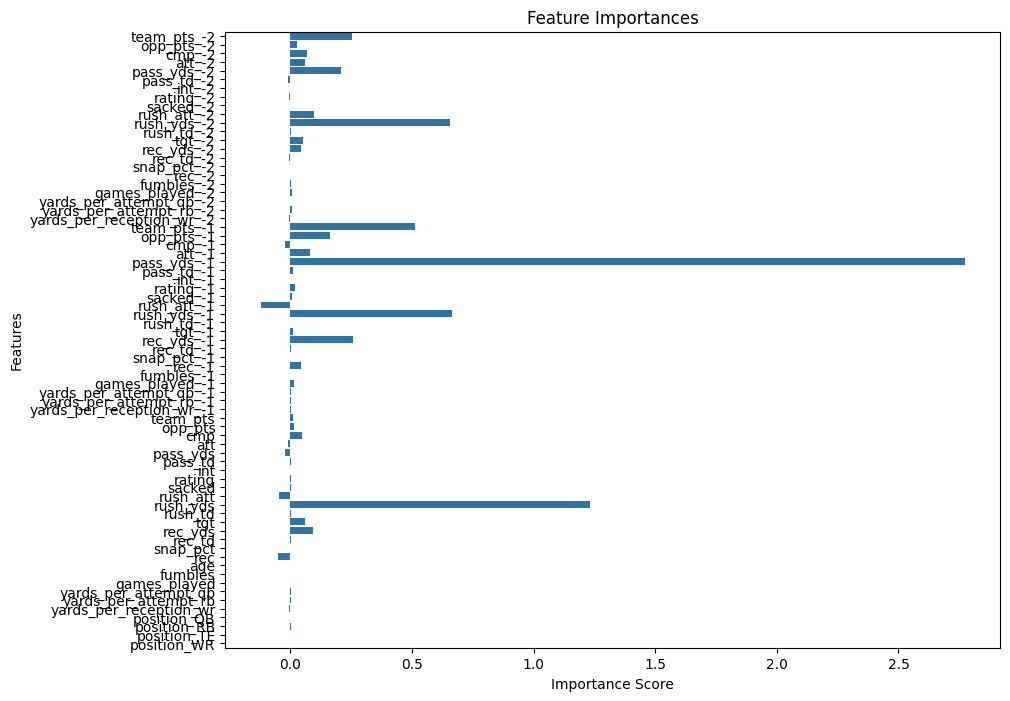

ValueError: not enough values to unpack (expected 3, got 2)

In [8]:
model_2022, params_2022, rmse_2022 = process_and_model(df_3yr_2)
print(f'Best Parameters: {params_2022}')
print(f'RMSE: {rmse_2022}')

In [10]:
df_3yr_full = pd.concat([df_3yr,df_3yr_2], ignore_index=True,axis=0)

Index(['name', 'team_pts_-2', 'opp_pts_-2', 'cmp_-2', 'att_-2', 'pass_yds_-2',
       'pass_td_-2', 'int_-2', 'rating_-2', 'sacked_-2', 'rush_att_-2',
       'rush_yds_-2', 'rush_td_-2', 'tgt_-2', 'rec_yds_-2', 'rec_td_-2',
       'snap_pct_-2', 'rec_-2', 'fumbles_-2', 'games_played_-2',
       'yards_per_attempt_qb_-2', 'yards_per_attempt_rb_-2',
       'yards_per_reception_wr_-2', 'team_pts_-1', 'opp_pts_-1', 'cmp_-1',
       'att_-1', 'pass_yds_-1', 'pass_td_-1', 'int_-1', 'rating_-1',
       'sacked_-1', 'rush_att_-1', 'rush_yds_-1', 'rush_td_-1', 'tgt_-1',
       'rec_yds_-1', 'rec_td_-1', 'snap_pct_-1', 'rec_-1', 'fumbles_-1',
       'games_played_-1', 'yards_per_attempt_qb_-1', 'yards_per_attempt_rb_-1',
       'yards_per_reception_wr_-1', 'team_pts', 'opp_pts', 'cmp', 'att',
       'pass_yds', 'pass_td', 'int', 'rating', 'sacked', 'rush_att',
       'rush_yds', 'rush_td', 'tgt', 'rec_yds', 'rec_td', 'snap_pct', 'rec',
       'age', 'fumbles', 'games_played', 'yards_per_attempt_

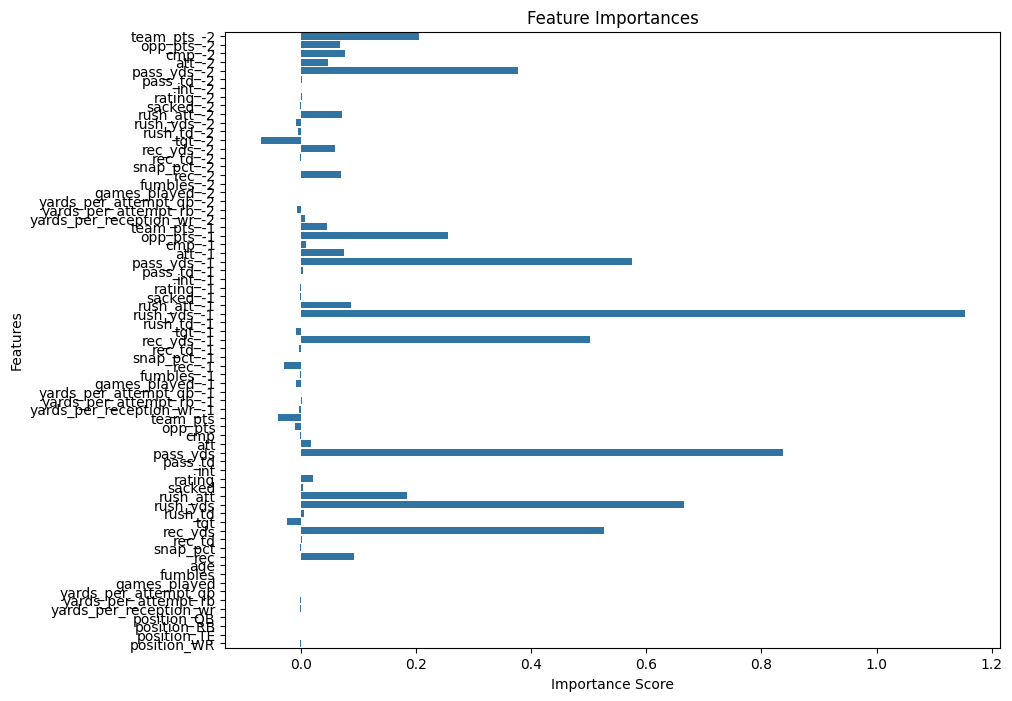

Best Parameters: {'batch_size': 10, 'epochs': 200, 'model__activation': 'relu', 'model__learning_rate': 0.0001, 'model__neurons': 32, 'model__optimizer': 'adam'}
RMSE: 64.68534645639991


In [11]:
model_full, params_full, rmse_full = process_and_model(df_3yr_2)
print(f'Best Parameters: {params_full}')
print(f'RMSE: {rmse_full}')